In [2]:

import os
import zipfile
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from google.colab import files

In [3]:

metadata_path = "/content/full_test_split.csv"


metadata = pd.read_csv(metadata_path)
metadata

,Participant_ID,PHQ_Binary,PHQ_Score,Gender
0,300,0,2,1
1,301,0,3,1
2,306,0,0,0
3,308,1,22,0
4,309,1,15,1
5,311,1,21,0
6,314,0,1,0
7,323,0,1,0
8,329,0,1,1
9,332,1,18,0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

train_zip_path = "/content/drive/MyDrive/Colab Notebooks/train.zip"
extracted_dir = "/content/train_wav"
os.makedirs(extracted_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# --- DATA UNZIPPING AND PREPARATION ---
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

train_folder = os.path.join(extracted_dir, "train")

wav_files = []
for inner_zip in os.listdir(train_folder):
    if inner_zip.endswith(".zip"):
        inner_zip_path = os.path.join(train_folder, inner_zip)
        with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
            for f in zip_ref.namelist():
                if f.endswith(".wav"):
                    zip_ref.extract(f, extracted_dir)
                    wav_files.append(os.path.join(extracted_dir, f))

print(f"Total wav files extracted: {len(wav_files)}")


Total wav files extracted: 15


In [6]:
train_meta = metadata.iloc[:12].reset_index(drop=True)
test_meta  = metadata.iloc[12:15].reset_index(drop=True)

wav_files_train = [f for f in wav_files if any(str(pid) in f for pid in train_meta['Participant_ID'])]
wav_files_test  = [f for f in wav_files if any(str(pid) in f for pid in test_meta['Participant_ID'])]

print(f"Train wav files: {len(wav_files_train)}")
print(f"Test wav files: {len(wav_files_test)}")

Train wav files: 10
Test wav files: 2


In [7]:
# --- FEATURE ENGINEERING FUNCTIONS ---
def chunk_audio(y, sr, chunk_duration=30):
    chunk_length = chunk_duration * sr
    chunks = []

    for start in range(0, len(y), chunk_length):
        chunk = y[start:start+chunk_length]
        if len(chunk) > 1000:
            chunks.append(chunk)
    return chunks


def extract_mfcc_chunk(y, sr, n_mfcc=40):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    return mfccs.T


In [8]:
# --- CNN/MFCC FEATURE PARAMETERS ---
max_len = 1300
n_mfcc = 40


X_all, y_all = [], []


for idx, row in train_meta.iterrows():
    pid = row['Participant_ID']
    wav_path = [f for f in wav_files_train if str(pid) in f]
    if not wav_path:
        continue
    y, sr = librosa.load(wav_path[0], sr=None)
    chunks = chunk_audio(y, sr)
    for chunk in chunks:
        mfcc_seq = extract_mfcc_chunk(chunk, sr)
        X_all.append(mfcc_seq)
        y_all.append(row['PHQ_Score'])

In [9]:
X_all = pad_sequences(X_all, maxlen=max_len, dtype='float32', padding='post', truncating='post')
X_flat = X_all.reshape(-1, n_mfcc)
scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)
X_all = X_flat.reshape(-1, X_all.shape[1], n_mfcc)
y_all = np.array(y_all)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


In [11]:
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # regression
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1300, 128)      │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1300, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,049 (539.25 KB)

 Trainable params: 138,049 (539.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 124.7587 - mae: 7.7641 - val_loss: 75.8921 - val_mae: 7.4606
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 77.5156 - mae: 7.8430 - val_loss: 67.3357 - val_mae: 7.8713
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 77.4440 - mae: 8.4078 - val_loss: 67.2770 - val_mae: 7.8545
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 77.2498 - mae: 8.4253 - val_loss: 67.2674 - val_mae: 7.8501
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 78.9314 - mae: 8.4129 - val_loss: 67.4366 - val_mae: 7.7802
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 70.9124 - mae: 7.9229 - val_loss: 67.3333 - val_mae: 7.7986
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 79.7235 - mae: 8.4223 - val_loss: 67.3055 - val_mae: 7.8055
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 73.0131 - mae: 8.0084 - val_loss: 67.4805 - val_mae: 7.7740
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82m

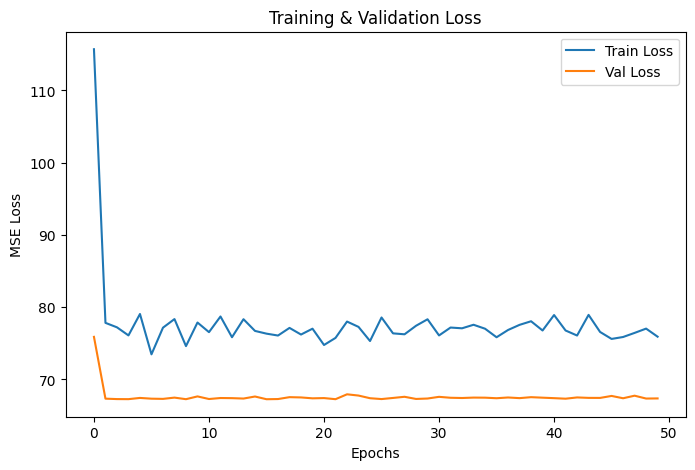

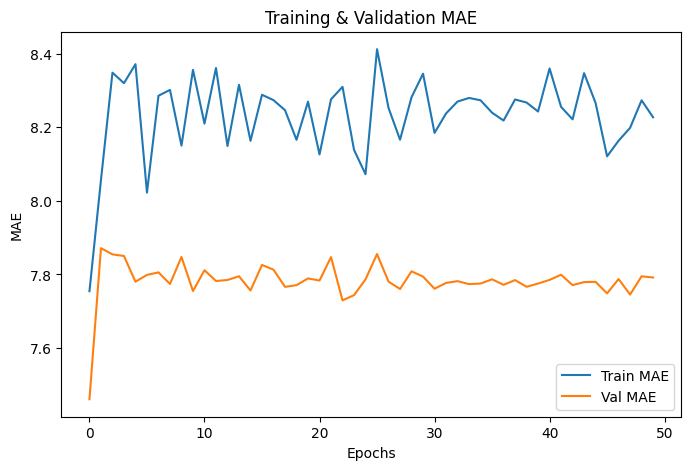

In [14]:
# --- LEARNING CURVE  ---

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("Training & Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


In [15]:
# EVALUATION 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_test_all, y_test_all = [], []

for idx, row in test_meta.iterrows():
    pid = row['Participant_ID']
    wav_path = [f for f in wav_files_test if str(pid) in f]
    if not wav_path:
        continue
    y, sr = librosa.load(wav_path[0], sr=None)
    chunks = chunk_audio(y, sr)
    for chunk in chunks:
        mfcc_seq = extract_mfcc_chunk(chunk, sr)
        X_test_all.append(mfcc_seq)
        y_test_all.append(row['PHQ_Score'])

X_test_all = pad_sequences(X_test_all, maxlen=max_len, dtype='float32', padding='post', truncating='post')
X_flat = X_test_all.reshape(-1, n_mfcc)
X_flat = scaler.transform(X_flat)
X_test_all = X_flat.reshape(-1, X_test_all.shape[1], n_mfcc)
y_test_all = np.array(y_test_all)


y_pred = model.predict(X_test_all)


mse = mean_squared_error(y_test_all, y_pred)
mae = mean_absolute_error(y_test_all, y_pred)
r2  = r2_score(y_test_all, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R2: {r2:.2f}")




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Test MSE: 40.41
Test MAE: 5.88
Test R2: -5.99


In [3]:
import pandas as pd
import numpy as np
import librosa
import os
import zipfile
import tensorflow as tf
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

# --- PARAMETER: TARGET COLUMN NAME ---
BINARY_TARGET_COLUMN = 'PHQ_Binary'
MODEL_FILENAME = 'final_lstm_phq_model.h5'
DRIVE_MODEL_PATH = f"/content/drive/MyDrive/Colab Notebooks/{MODEL_FILENAME}"
# ------------------------------------
TRAINING_EPOCHS = 30
TRAINING_VERBOSE = 1
# --- LSTM/MFCC PARAMETERS ---
N_MFCC = 20
MAX_LEN = 500
LSTM_UNITS = 64
DROPOUT_RATE = 0.5 
L2_REG = 1e-4
# ---------------------------

metadata_path = "/content/full_test_split.csv"

metadata = pd.read_csv(metadata_path)

drive.mount('/content/drive')


# UNZIPPING AUDIO .WAV FILES
train_zip_path = "/content/drive/MyDrive/Colab Notebooks/train.zip"
extracted_dir = "/content/train_wav"
os.makedirs(extracted_dir, exist_ok=True)

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

train_folder = os.path.join(extracted_dir, "train")

wav_files = []
for inner_zip in os.listdir(train_folder):
    if inner_zip.endswith(".zip"):
        inner_zip_path = os.path.join(train_folder, inner_zip)
        with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
            for f in zip_ref.namelist():
                if f.endswith(".wav"):
                    zip_ref.extract(f, extracted_dir)
                    wav_files.append(os.path.join(extracted_dir, f))

train_meta = metadata.iloc[:12].reset_index(drop=True)
test_meta = metadata.iloc[12:15].reset_index(drop=True)

wav_files_train = [f for f in wav_files if any(str(pid) in f for pid in train_meta['Participant_ID'])]
wav_files_test = [f for f in wav_files if any(str(pid) in f for pid in test_meta['Participant_ID'])]



def chunk_audio(y, sr, chunk_duration=30):
    chunk_length = chunk_duration * sr
    chunks = []

    for start in range(0, len(y), chunk_length):
        chunk = y[start:start+chunk_length]
        if len(chunk) > 1000:
            chunks.append(chunk)
    return chunks

# --- MFCC FEATURE EXTRACTION ---
def extract_mfcc_chunk(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    return mfccs.T


X_all_train_list, y_all_train_binary, groups_all_train = [], [], []
X_test_all_list, y_test_all_binary = [], []

print("Extracting MFCC features (1/2: Training Data)...")
for idx, row in train_meta.iterrows():
    pid = row['Participant_ID']
    wav_path = [f for f in wav_files_train if str(pid) in f]
    if not wav_path:
        continue
    y, sr = librosa.load(wav_path[0], sr=22050)

    chunks = chunk_audio(y, sr)
    for chunk in chunks:
        feature_sequence = extract_mfcc_chunk(chunk, sr)
        X_all_train_list.append(feature_sequence)
        y_all_train_binary.append(row[BINARY_TARGET_COLUMN])
        groups_all_train.append(pid)

print("Extracting MFCC features (2/2: Test Data)...")
for idx, row in test_meta.iterrows():
    pid = row['Participant_ID']
    wav_path = [f for f in wav_files_test if str(pid) in f]
    if not wav_path:
        continue
    y, sr = librosa.load(wav_path[0], sr=22050)
    chunks = chunk_audio(y, sr)
    for chunk in chunks:
        feature_sequence = extract_mfcc_chunk(chunk, sr)
        X_test_all_list.append(feature_sequence)
        y_test_all_binary.append(row[BINARY_TARGET_COLUMN])

#  PREPROCESSING: Padding Sequences and Scaling 

X_all_train = pad_sequences(X_all_train_list, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')
X_test_all = pad_sequences(X_test_all_list, maxlen=MAX_LEN, dtype='float32', padding='post', truncating='post')

scaler = StandardScaler()
X_flat_train = X_all_train.reshape(-1, N_MFCC)
X_flat_train_scaled = scaler.fit_transform(X_flat_train)
X_all_train = X_flat_train_scaled.reshape(X_all_train.shape[0], MAX_LEN, N_MFCC)

y_all_train = np.array(y_all_train_binary).astype(int)
groups_all_train = np.array(groups_all_train)
y_test_all = np.array(y_test_all_binary).astype(int)



input_shape = (MAX_LEN, N_MFCC)

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(LSTM_UNITS, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(L2_REG)),
        Dropout(DROPOUT_RATE),

        LSTM(LSTM_UNITS // 2, kernel_regularizer=l2(L2_REG)),
        Dropout(DROPOUT_RATE),

        Dense(LSTM_UNITS // 4, activation='relu', kernel_regularizer=l2(L2_REG)),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
   
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def evaluate_classification(y_true, y_pred_proba):
    y_pred = (y_pred_proba > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred_proba)
    except ValueError:
        auc = 0.5

    return acc, prec, rec, f1, auc


n_splits = 4
gkfold = GroupKFold(n_splits=n_splits)
fold_results = []
fold_num = 1


for train_index, val_index in gkfold.split(X_all_train, y_all_train, groups=groups_all_train):
    print(f"\n--- Starting CV Fold {fold_num}/{n_splits} ---")

    X_train, X_val = X_all_train[train_index], X_all_train[val_index]
    y_train, y_val = y_all_train[train_index], y_all_train[val_index]

    model = create_lstm_model(input_shape=input_shape)

    callbacks = [
        ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    ]

    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=TRAINING_EPOCHS,
        batch_size=8,
        callbacks=callbacks,
        verbose=TRAINING_VERBOSE 
    )

    y_pred_proba = model.predict(X_val, verbose=0)

    acc, prec, rec, f1, auc = evaluate_classification(y_val, y_pred_proba)

    print(f"Fold {fold_num} Metrics: Accuracy={acc:.2f}, AUC={auc:.2f}, F1={f1:.2f}, Precision={prec:.2f}, Recall={rec:.2f}")

    fold_results.append({'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc})
    fold_num += 1


avg_acc = np.mean([res['acc'] for res in fold_results])
avg_auc = np.mean([res['auc'] for res in fold_results])
avg_f1 = np.mean([res['f1'] for res in fold_results])

print("\n-------------------------------------------")
print(f"AVERAGE {n_splits}-FOLD CROSS-VALIDATION RESULTS (12 Participants):")
print(f"Target: {BINARY_TARGET_COLUMN} (0/1)")
print(f"Average Accuracy: {avg_acc:.4f}")
print(f"Average AUC Score: {avg_auc:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print("-------------------------------------------")


print("\n--- Preparing Final Model (Load Existing or Train New) ---")

# Attempt to load the model for fine-tuning
final_model = load_model_from_drive(DRIVE_MODEL_PATH)

# If model wasn't loaded (first run), create it from scratch
if final_model is None:
    print("Training new final model from scratch.")
    tf.keras.backend.clear_session()
    final_model = create_lstm_model(input_shape=input_shape)
else:
    print(f"Continuing training (Fine-Tuning) the existing model for {TRAINING_EPOCHS} more epochs.")
    tf.keras.backend.set_value(final_model.optimizer.learning_rate, 1e-5) # Fine-tune with a very small learning rate

# Train the final model (or continue training the loaded one)
final_model.fit(
    X_all_train,
    y_all_train,
    epochs=TRAINING_EPOCHS,
    batch_size=8,
    verbose=TRAINING_VERBOSE
)

# Save the final (newly trained or fine-tuned) model
save_model_to_drive(final_model, DRIVE_MODEL_PATH)


# --- Evaluate on the true 3-Participant Test Set ---

# Apply scaling to test set and evaluate
X_flat_test = X_test_all.reshape(-1, N_MFCC)
X_flat_test_scaled = scaler.transform(X_flat_test)
X_test_scaled = X_flat_test_scaled.reshape(X_test_all.shape[0], MAX_LEN, N_MFCC)


print("\n--- FINAL TEST SET RESULTS (3 Held-Out Participants) ---")

y_pred_proba = final_model.predict(X_test_scaled, verbose=0)

acc, prec, rec, f1, auc = evaluate_classification(y_test_all, y_pred_proba)

print(f"Test Accuracy: {acc:.2f}")
print(f"Test AUC Score: {auc:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print("-----------------------------------------------------")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting MFCC features (1/2: Training Data)...
Extracting MFCC features (2/2: Test Data)...

--- Starting CV Fold 1/4 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.4993 - auc: 0.5166 - loss: 0.7165 - val_accuracy: 0.5556 - val_auc: 0.8154 - val_loss: 0.7065 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6363 - auc: 0.6888 - loss: 0.6490 - val_accuracy: 0.6049 - val_auc: 0.8103 - val_loss: 0.7040 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6713 - auc: 0.7562 - loss: 0.5865 - val_accuracy: 0.6173 - val_auc: 0.8081 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7761 - auc: 0.8794 - loss: 0.4898 - val_accuracy: 0.6543 - val_auc: 0.8074 - val_loss: 0.7010 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8265 - auc: 0.9129 - loss: 0.4115 - val_accuracy: 0.6790 - val_auc: 0.7924 - val_loss: 0.7254 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8801 - auc: 0.9661 -

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6213 - auc: 0.6527 - loss: 0.6562 - val_accuracy: 0.3165 - val_auc: 0.6081 - val_loss: 0.8119 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6591 - auc: 0.5585 - loss: 0.6240 - val_accuracy: 0.3671 - val_auc: 0.7285 - val_loss: 1.1012 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.6894 - auc: 0.8040 - loss: 0.5254 - val_accuracy: 0.6203 - val_auc: 0.8724 - val_loss: 1.1466 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8006 - auc: 0.8882 - loss: 0.3662 - val_accuracy: 0.4177 - val_auc: 0.7588 - val_loss: 2.4124 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8676 - auc: 0.8885 - loss: 0.3942 - val_accuracy: 0.6329 - val_auc: 0.8481 - val_loss: 1.5904 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8559 - auc: 0.9191 - loss: 0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5901 - auc: 0.6126 - loss: 0.6810 - val_accuracy: 0.3860 - val_auc: 0.0000e+00 - val_loss: 0.7915 - learning_rate: 0.0010
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6966 - auc: 0.7795 - loss: 0.5965 - val_accuracy: 0.3333 - val_auc: 0.0000e+00 - val_loss: 0.8710 - learning_rate: 0.0010
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7808 - auc: 0.8799 - loss: 0.4763 - val_accuracy: 0.3333 - val_auc: 0.0000e+00 - val_loss: 0.9608 - learning_rate: 0.0010
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8551 - auc: 0.9106 - loss: 0.3998 - val_accuracy: 0.2456 - val_auc: 0.0000e+00 - val_loss: 1.2073 - learning_rate: 0.0010
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8563 - auc: 0.9511 - loss: 0.3600 - val_accuracy: 0.2632 - val_auc: 0.0000e+00 - val_loss: 1.3090 - learning_rate: 0.0010
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9150 - auc:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Fold 3 Metrics: Accuracy=0.30, AUC=nan, F1=0.00, Precision=0.00, Recall=0.00

--- Starting CV Fold 4/4 ---
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5236 - auc: 0.5093 - loss: 0.7054 - val_accuracy: 0.4737 - val_auc: 0.1626 - val_loss: 0.7687 - learning_rate: 0.0010
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6340 - auc: 0.6876 - loss: 0.6539 - val_accuracy: 0.4561 - val_auc: 0.1392 - val_loss: 0.9017 - learning_rate: 0.0010
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7657 - auc: 0.8061 - loss: 0.5794 - val_accuracy: 0.4737 - val_auc: 0.0782 - val_loss: 1.1711 - learning_rate: 0.0010
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7752 - auc: 0.8501 - loss: 0.5011 - val_accuracy: 0.4561 - val_auc: 0.1053 - val_loss: 1.5822 - learning_rate: 0.0010
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8747 - auc: 0.9564 - loss: 0.3396 - val_accuracy: 0.4737 - val_auc: 0.2241 - val_loss: 2.0279 - learning_rate: 0.0010
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9101 - auc: 0.9360 - loss: 0.32

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5074 - auc: 0.4804 - loss: 0.7178
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6394 - auc: 0.6773 - loss: 0.6758
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7189 - auc: 0.7738 - loss: 0.5787
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7231 - auc: 0.8572 - loss: 0.4892
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8074 - auc: 0.8839 - loss: 0.4789
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8390 - auc: 0.9090 - loss: 0.3934
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8367 - auc: 0.8831 - loss: 0.4304
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6586 - auc: 0.7472 - loss: 0.5790
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6767 - auc: 0.7927 - loss: 0.5385
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7362 - auc: 0.8624 - loss: 0.4874
Epoch 11/30
35/35 ━━


--- Model successfully saved to /content/drive/MyDrive/Colab Notebooks/final_lstm_phq_model.h5 ---

--- FINAL TEST SET RESULTS (3 Held-Out Participants) ---
Test Accuracy: 0.56
Test AUC Score: nan
Test F1 Score: 0.72
-----------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
